In [3]:
using NBInclude
using LinearAlgebra
using Plots; pyplot()
using JLD, FileIO
using DataFrames, CSV
using LsqFit
using LaTeXStrings

In [4]:
@nbinclude("fftFilter2d.ipynb")

make2DSurfs (generic function with 2 methods)

In [5]:
function tau(z; dl=5)
    """
    returns Lp/L, averaged over every dl lines
    """
    L =size(z,1)
    Lp  = 0.0
    count=0
    for j=1:dl:L # eval Lp for each line
        count+=1
        for i=1:L-1
            v1 = [1; 0; z[j,i+1] - z[j,i]]    
            Lp += norm(v1)
        end
    end
    Lp /=count
    return Lp/L
end

tau (generic function with 1 method)

In [6]:
#sa = make2DSurfs(; maxlevel=10, hursts=0.3:0.05:0.85, samples=1:10, atol=0.01)

In [7]:
files = ["level8.jld", "level9.jld", "level10.jld"]
ss = [:l8, :l9, :l10]
df = DataFrame()
df2 = DataFrame()
for (n,file) in enumerate(files)
    sa=load(file)
    hurst = sa["hursts"]
    if n==1 
        df[:h] = hurst
        df2[:h] = hurst
    end
    
    τ = []
    σ = []
    nsamples = size(sa["samples"],1)
    for h in hurst
        τav = 0.0
        sav = 0.0
        for s in sa["samples"]
            z = sa["$h"]["$s"]
            τav += tau(z)
            sav += std(z)
        end
        push!(τ, τav/nsamples)
        push!(σ, sav/nsamples)
    end
    df[!,ss[n]] = τ
    df2[!,ss[n]] = σ
end
df

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[7]:9
└ @ Core ./In[7]:9
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[7]:10
└ @ Core ./In[7]:10


,h,l8,l9,l10
,Float64,Any,Any,Any
1,0.3,1.36662,1.26266,1.18647
2,0.35,1.26116,1.17515,1.1148
3,0.4,1.18582,1.11474,1.06999
4,0.45,1.1323,1.07485,1.04194
5,0.5,1.09072,1.04829,1.02503
6,0.55,1.06362,1.03084,1.01479
7,0.6,1.04435,1.01995,1.00867
8,0.65,1.03129,1.01263,1.00495
9,0.7,1.0221,1.00795,1.00283


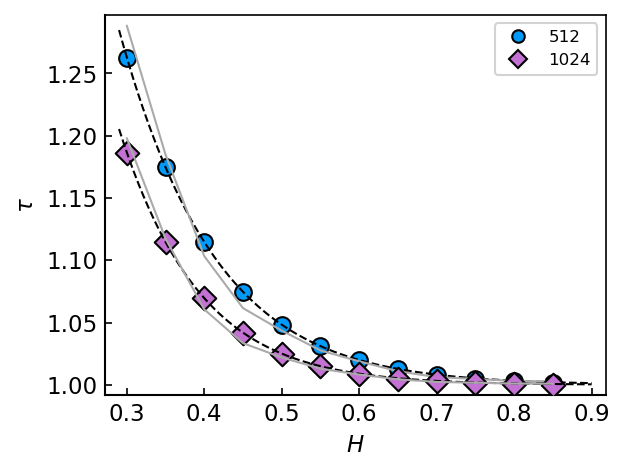

512,[2.9625242394880846, 1.4428712716425733, 511.999488]
1024,[3.047486259476302, 1.401096083088609, 1023.9989784152986]


In [94]:
p1 = plot(size=(400,300),
              legendfontsize=8,
              legend=:inside,
              bottommargin=50,
              fg_legend=:lightgray, 
              dpi=150, frame=:box,
              xaxis=(L"H", font(11)),
              yaxis=(L"τ", font(11)),
              grid=false)
@. model(x,p) = sqrt(1.0 + (p[1]^2)*(4*p[2]/p[3])^(2*x))
x = df.h 
dx = []
c = []
N = [1, 2^8, 2^9,  2^10]
for (n,col) in enumerate([1,df.l8, df.l9, df.l10])
    if n>2
        y = col
        ℓ =  N[n]
        p=curve_fit(model,x,y, [5.0, 1.0, N[n]], lower=[0.0, 1.0, 0.999999*ℓ], upper=[5, 2, 1.0*ℓ])
        println(N[n], ",", p.param)
        push!(dx, p.param[2])
        push!(c, p.param[1])
        
        xfit = range(0.29, stop=0.9, length=100)
        yfit = model(xfit, p.param)
        
        scatter!(x, y, marker=:auto, markersize=8, label="$ℓ")
        plot!(xfit, yfit, linestyle=:dash, color=:black, label="")
        
        xfit2 = df2.h
        yfit2 = sqrt.(1 .+ (df2.l9).^2 .* ((4/N[n]).^(2*df.h)))
        plot!(xfit2, yfit2, color="#aaaaaa", label="")

    end
end
p1
savefig("/home/humberto/OneD/Documentos/Petrobras/figs/tau.png")

In [39]:
df2.l9

12-element Array{Any,1}:
 3.482699474446478 
 3.4724242152825844
 3.246563090191988 
 3.163072246973666 
 3.3742536037788016
 3.412173266503946 
 3.5855228689582233
 3.472462938144953 
 3.3207842696990766
 3.7265260485503036
 3.8040149498010387
 4.65039190316268  